In [23]:
# Useful starting lines
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../')
from utils.implementation_utils import *
from utils.preprocessing_utils import *
import datetime
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from utils.io_utils import *
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, tXt, ids = load_csv_data(DATA_TRAIN_PATH)
print(y.shape, tX.shape)

(250000,) (250000, 30)


In [11]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [12]:
sample_range = [0, 2000]
X_sample = tX[sample_range[0] : sample_range[1]]
y_sample = y[sample_range[0] : sample_range[1]]
ids_sample = ids[sample_range[0] : sample_range[1]]
pd.DataFrame(y_sample)

,0
0,1.0
1,-1.0
2,-1.0
3,-1.0
4,-1.0
...,...
1995,1.0
1996,-1.0
1997,-1.0
1998,1.0


In [13]:
rmv_indx = [0, 2, 3, 4, 6, 8, 12, 20, 23]
test_list, y_list, ids_list = split_data_for_test_submit(ids_sample, X_sample, y_sample, rmv_indx)
#y_pred = predict_label()
# Store prediction in a list, Here we need to replace y_list by prediction_list
y_r = np.concatenate((y_list[0], y_list[1], y_list[2], y_list[3]), axis=0)[:, np.newaxis]
ids_r = np.concatenate((ids_list[0], ids_list[1], ids_list[2], ids_list[3]), axis=0)[:, np.newaxis]
sorted_arr = np.concatenate((ids_r, y_r), axis=1)
sorted_arr = sorted_arr[sorted_arr[:, 0].argsort()]
rec_y = np.squeeze(np.delete(sorted_arr, 0, axis=1))
sum_ = sum(y_sample - rec_y)
print(sum_)
pd.DataFrame([y_sample, rec_y])

0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,

In [4]:
from utils.io_utils import *
DATA_TRAIN_PATH = '../data/test.csv' # TODO: download train data and supply path here 
y_te, tX_te, tXt, ids_te = load_csv_data(DATA_TRAIN_PATH)
print(y.shape, tX.shape)

(250000,) (250000, 30)


In [25]:
new_data, _, rmv_ind = preprocess_train_data_split(tX, y)

[ 4  5  6  8 12 22 23 24 25 26 27 28 29]
[ 3  4  5  6  9 12 22 23 26 27 28]
[22 23 29]
[21 22 29]


In [37]:
data_list, y_list, feat_ind = subdivide_data(tX, y)
new_data_list = []
for tx, y in zip(data_list, y_list):
    new_data_list.append(new_data)

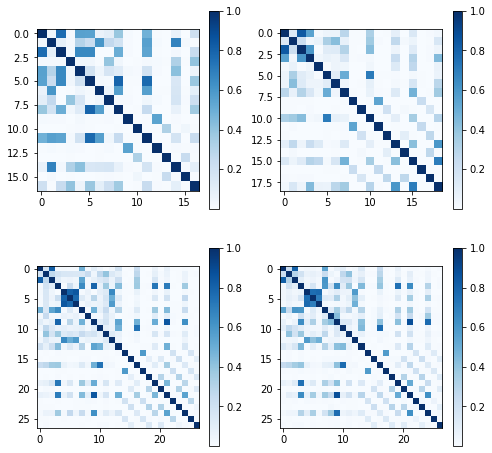

In [41]:
corr_mat_0 = np.ma.corrcoef(new_data[0], rowvar=False)
corr_mat_1 = np.ma.corrcoef(new_data[1], rowvar=False)
corr_mat_2 = np.ma.corrcoef(new_data[2], rowvar=False)
corr_mat_3 = np.ma.corrcoef(new_data[3], rowvar=False)

corr_mat_list = [corr_mat_0, corr_mat_1, corr_mat_2, corr_mat_3]

#for i, corr in enumerate(corr_mat_list):
#    corr_mat_list[i][corr < 0.9] = 0
#    corr_mat_list[i][corr >= 0.9] = 1

fig = plt.figure(figsize=(8, 8))
for i in range(1, 5):
    fig.add_subplot(2, 2, i)
    plt.imshow(np.abs(corr_mat_list[i - 1]), cmap='Blues')
    plt.colorbar()
plt.show()
    
#plt.imshow(np.abs(corr_mat), cmap='Blues')
#plt.colorbar()
#plt.show()

In [96]:
corr_indices = np.argwhere(np.abs(np.triu(corr_mat - np.eye(30))) > 0.8)
print(corr_indices)

[[ 0  2]
 [ 3  9]
 [ 3 23]
 [ 3 29]
 [ 4  5]
 [ 9 21]
 [ 9 23]
 [ 9 29]
 [21 29]
 [22 29]
 [23 29]
 [26 29]]


In [97]:
unique_ind1 = np.unique(corr_indices[:, 0])
unique_ind2 = np.unique(corr_indices[:, 1])
print(unique_ind1, unique_ind2)

[ 0  3  4  9 21 22 23 26] [ 2  5  9 21 23 29]


In [98]:
len1 = len(unique_ind1)
len2 = len(unique_ind2)
corr_ind_reduce_short = (unique_ind1, unique_ind2)[len(unique_ind1) > len(unique_ind2)]
corr_ind_reduce_big = (unique_ind1, unique_ind2)[len(unique_ind1) < len(unique_ind2)]
corr_ind_to_keep = []
for ind in corr_ind_reduce_short:
    is_in = np.isin(ind, corr_ind_reduce_big)
    if not is_in:
        corr_ind_to_keep.append(ind)

In [99]:
all_ind = np.unique(corr_indices.flatten())
print(all_ind.shape)

(11,)


In [100]:
corr_ind_to_throw = np.setdiff1d(all_ind, corr_ind_to_keep)

In [101]:
np.array(corr_ind_to_keep), corr_ind_to_throw

(array([ 2,  5, 29]), array([ 0,  3,  4,  9, 21, 22, 23, 26]))

In [107]:
keep, throw = feature_selection(new_data, 0.8)

In [108]:
keep, throw

(array([ 2,  5, 29]), array([ 0,  3,  4,  9, 21, 22, 23, 26]))

In [19]:
ind = np.array((rmv_ind[0], rmv_ind[1]))
print(ind)

[array([ 4,  5,  6,  8, 12, 22, 23, 24, 25, 26, 27, 28, 29])
 array([ 3,  4,  5,  6,  9, 12, 22, 23, 26, 27, 28])]


/Users/AntoineDaeniker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [6]:
ws = load_csv_data('../sgd_model_split.csv')

ValueError: Some errors were detected !
    Line #3 (got 29 columns instead of 21)
    Line #4 (got 28 columns instead of 21)